In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

## Patches embedding
##### 1. Conv layer를 활용하여 패치 나누기 
(논문의 Hybrid Architecture로 언급)
##### 2. Trainable linear projection을 통해 x의 각 패치를 flatten한 벡터를 D차원으로 변환한 후, 이를 패치 임베딩으로 사용

##### 3. Learnable 임베딩과 패치 임베딩에 learnable position 임베딩을 더함

In [2]:
class PatchEmbedding(nn.Module):
    def __init__(self, input_channels, patch_size,                                                  # input_channels : channel
                 embedding_size, img_size):
        self.patch_size = patch_size
        super().__init__()
        self.partition = nn.Sequential(                                                             # Conv layer를 활용하여 patch 나누기 (Hybrid Architecture)
                nn.Conv2d(input_channels, embedding_size,
              kernel_size=patch_size, stride=patch_size),                                           # torch.Size([1, 768, 14, 14])
                 Rearrange('b e (h) (w) -> b (h w) e')                                              # tenser의 차원을 변환 b: batch_size, e: embeding_size, h: height, w: width
        )                                                                                           # (h w)를 통해 height와 width를 결합하여 총 패치 수로 변환 (패치 한줄서기)
        self.cls_token = nn.Parameter(torch.randn(1,1, embedding_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, embedding_size))
    
    def forward(self, x):
        b, _, _, _ = x.shape                                                                        # x.shape에서 batch_size만 필요하여 b 변수에 batch_size만 저장
        x = self.partition(x)                                                                       # flatten 과정
        cls_token = repeat(self.cls_token, '() n e -> b n e', b=b )                                 # cls_token을 배치 크기에 맞춰 복제
                                                                                                    # (배치 크기, cls_token 개수, 임베딩 크기)
        x = torch.cat([cls_token, x], dim=1)                                                        # ([1, 196 + 1, 768])  dim=1로 설정해서 cls_token을 패치 앞에 추가
        x += self.positions                                                                         # position embedding 더하기

        return x

## Transformer encoder
##### 4. 임베딩을 Transformer encode에 input으로 넣어 마지막 layer에서 class embedding에 대한 output인 image representation을 도출

#### 1. Multi-Head Attention
패치에 대해 self-attention 메커니즘 적용

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, 
                 embedding_size,
                 num_heads,
                 dropout):
        super().__init__()
        self.embedding_size = embedding_size
        self.num_heads = num_heads
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(embedding_size, embedding_size * 3)                                # query, key, value를 계산하기 위한 선형 변환
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(embedding_size, embedding_size)

    def forward(self, x, mask):
        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3) # batch_size(b), num_head(h), n(시퀀스 길이), head_dim(d) = emb_size/head(각 head의 차원)
                                                                                                # rearrange에서 "b n (h d)" 여기서 h d는 embedding_size를 두 개의 차원인 h와 d로 나누라는 의미
                                                                                                # embedding_size = h * d가 되므로, rearrange는 자동으로 embedding/num_heads를 d로 정의
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # sum up over the last axis
        score = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)                               # Queries * Keys(transpose) 내적 => 'bhqd, bhkd -> bhqk' queries와 key 간의 내적을 계산하는 부분
                                                                                                # b: batch_size, h: num_head, q: query_len(query의 시퀀스 길이), d: head_dim(각 헤드에서의 차원) => 'bhqd'
                                                                                                # b: batch_size, h: num_head, q: key_len(key의 시퀀스 길이), d: head_dim(각 헤드에서의 차원)     => 'bhkd'
                                                                                                # 'qd' * 'kd' 내적 -> 'bhqk'가 됨
        
        scaling = self.embedding_size ** (1/2)                                                  # scaling factor
        attention = F.softmax(score / scaling, dim=-1)                                          # attention 최종 계산
        attention = self.att_drop(attention)                                                    # Dropout
        
        output = torch.einsum('bhal, bhlv -> bhav', attention, values)                          # attention * values 내적 => (batch_size, num_heads, query_len, head_dim)
        output = rearrange(output, "b h n d -> b n (h d)")                                      # (batch_size, query_len, embedding_size)
        output = self.projection(output)                                                        # 선형 변환하여 최종적으로 원래 embedding_size로 변환
                                                                                                # MHA의 결과들을 다시 하나의 임베딩 벡터로 변환

        return output

### 2. Transformer Encoder Block
MLP(Feed Forward) 블럭을 만들어주도 Multi Head Attention을 하나로 묶음

In [4]:
class ResidualAdd(nn.Module):       # residual part
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    
    def forward(self, x, **kwargs):
        res = x                     # 기존 x를 res 변수에 저장
        x = self.fn(x, **kwargs)
        x += res                    # MHA or MLP에서 나온 결과 x와 기존 x를 merge
        return x

class FeedForwardBlock(nn.Sequential):  #MLP Block -> 어텐션으로 추출된 정보를 더 깊게 처리
    def __init__(self, embedding_size, expansion, drop_p):
        super().__init__(
            nn.Linear(embedding_size, expansion * embedding_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * embedding_size, embedding_size)
        )

class TransformerEncoderBlock(nn.Sequential):   # TransformerEncoder의 전체적인 구조 
    def __init__(self, embedding_size,
                 drop_p,
                 forward_expansion,
                 forward_drop_p,
                 **kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(embedding_size),
                MultiHeadAttention(embedding_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(embedding_size),
                FeedForwardBlock(embedding_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            ))
        )


## Classification Head
##### 5. classification을 위한 MLP Head 부분

In [5]:
class TransformerEncoder(nn.Sequential):    # Transformer를 얼마나 쌓아 올린 것인지
    def __init__(self, depth, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])    # depth에 따라 TransformerEncoderBlock을 여러 개 쌓아올림

class ClassificationHead(nn.Sequential):                # Transformer 모델의 출력을 받아 classification task 진행
    def __init__(self, embedding_size,
                 n_classes):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),   # 모든 패치의 임베딩을 평균 내어 하나의 임베딩 벡터로 축소
            nn.LayerNorm(embedding_size),
            nn.Linear(embedding_size, n_classes)
        )

class ViT(nn.Sequential):                               # 각 모듈을 순차적으로 수행
    def __init__(self,
                 input_channels,
                 patch_size,
                 embedding_size,
                 img_size,
                 depth,
                 n_classes, 
                 num_heads,
                 dropout,
                 **kwargs):
        super().__init__(
            PatchEmbedding(input_channels, patch_size, embedding_size, img_size),
            TransformerEncoder(depth, embedding_size=embedding_size, num_heads=num_heads, dropout=dropout, **kwargs),
            ClassificationHead(embedding_size, n_classes)
        )

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 625/625 [04:26<00:00,  2.35it/s]


Epoch [1/50] - Train Loss: 3.9902, Train Acc: 0.0853, Val Loss: 3.6062, Val Acc: 0.1362
Validation loss decreased (inf --> 3.606250).  Saving model ...


100%|██████████| 625/625 [04:31<00:00,  2.30it/s]


Epoch [2/50] - Train Loss: 3.3309, Train Acc: 0.1855, Val Loss: 3.1742, Val Acc: 0.2068
Validation loss decreased (3.606250 --> 3.174219).  Saving model ...


100%|██████████| 625/625 [04:30<00:00,  2.31it/s]


Epoch [3/50] - Train Loss: 2.9675, Train Acc: 0.2554, Val Loss: 2.9235, Val Acc: 0.2687
Validation loss decreased (3.174219 --> 2.923504).  Saving model ...


100%|██████████| 625/625 [04:31<00:00,  2.30it/s]


Epoch [4/50] - Train Loss: 2.6779, Train Acc: 0.3160, Val Loss: 2.7715, Val Acc: 0.2933
Validation loss decreased (2.923504 --> 2.771541).  Saving model ...


100%|██████████| 625/625 [04:31<00:00,  2.30it/s]


Epoch [5/50] - Train Loss: 2.4152, Train Acc: 0.3699, Val Loss: 2.6513, Val Acc: 0.3241
Validation loss decreased (2.771541 --> 2.651350).  Saving model ...


100%|██████████| 625/625 [04:31<00:00,  2.31it/s]


Epoch [6/50] - Train Loss: 2.1537, Train Acc: 0.4249, Val Loss: 2.5640, Val Acc: 0.3501
Validation loss decreased (2.651350 --> 2.564023).  Saving model ...


100%|██████████| 625/625 [04:31<00:00,  2.30it/s]


Epoch [7/50] - Train Loss: 1.8871, Train Acc: 0.4857, Val Loss: 2.5198, Val Acc: 0.3644
Validation loss decreased (2.564023 --> 2.519765).  Saving model ...


100%|██████████| 625/625 [04:31<00:00,  2.30it/s]


Epoch [8/50] - Train Loss: 1.6027, Train Acc: 0.5563, Val Loss: 2.4877, Val Acc: 0.3785
Validation loss decreased (2.519765 --> 2.487733).  Saving model ...


100%|██████████| 625/625 [04:31<00:00,  2.30it/s]


Epoch [9/50] - Train Loss: 1.2720, Train Acc: 0.6419, Val Loss: 2.5741, Val Acc: 0.3797
EarlyStopping counter: 1 out of 5


100%|██████████| 625/625 [04:31<00:00,  2.30it/s]


Epoch [10/50] - Train Loss: 0.9298, Train Acc: 0.7343, Val Loss: 2.6998, Val Acc: 0.3762
EarlyStopping counter: 2 out of 5


100%|██████████| 625/625 [04:31<00:00,  2.30it/s]


Epoch [11/50] - Train Loss: 0.3634, Train Acc: 0.9202, Val Loss: 2.5189, Val Acc: 0.4184
EarlyStopping counter: 3 out of 5


100%|██████████| 625/625 [04:31<00:00,  2.30it/s]


Epoch [12/50] - Train Loss: 0.2239, Train Acc: 0.9643, Val Loss: 2.5622, Val Acc: 0.4184
EarlyStopping counter: 4 out of 5


100%|██████████| 625/625 [04:31<00:00,  2.30it/s]


Epoch [13/50] - Train Loss: 0.1628, Train Acc: 0.9792, Val Loss: 2.6018, Val Acc: 0.4176
EarlyStopping counter: 5 out of 5
Early stopping


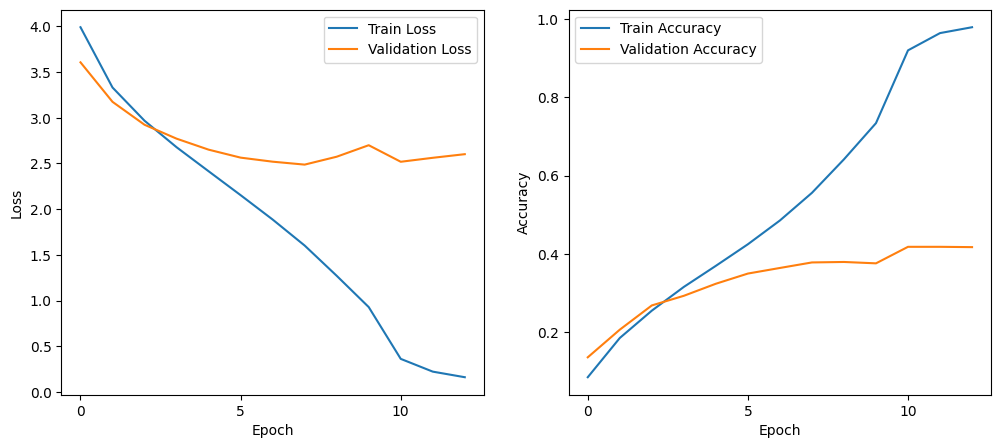

C:\Users\user\AppData\Local\Temp\ipykernel_18744\3226603696.py:188: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{CHECKPOINT_DIR}/best_mo

FileNotFoundError: [Errno 2] No such file or directory: './checkpoints//best_model_epoch_13.pth'

In [6]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import torch.optim as optim
from tqdm import tqdm
import os

# Training settings
BATCH_SIZE = 64
EPOCHS = 20
LR = 1e-4
CHECKPOINT_DIR = './checkpoints/'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# CIFAR-10 dataset loading with transforms
transform = Compose([
    Resize((224, 224)),  # ViT expects 224x224 images
    ToTensor(),
    Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])  # CIFAR-10 normalization
])

# Load CIFAR-10 dataset
train_dataset = CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = CIFAR10(root='./data', train=False, transform=transform, download=True)

# Split train into train/validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# DataLoader for train, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize model
model = ViT(input_channels=3, patch_size=16, embedding_size=768, img_size=224, depth=12, n_classes=10).to(DEVICE)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Function to save model checkpoint
def save_checkpoint(epoch, model, optimizer, path):
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    if not os.path.exists(CHECKPOINT_DIR):
        os.makedirs(CHECKPOINT_DIR)
    torch.save(state, path)

# Training and validation loop
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    for imgs, labels in tqdm(train_loader):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{EPOCHS}] - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Save model checkpoint
    save_checkpoint(epoch, model, optimizer, f'{CHECKPOINT_DIR}/vit_epoch_{epoch+1}.pth')
    
    # Adjust learning rate
    scheduler.step()

# Plotting the training loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Test the model on test dataset
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")
